In [12]:
%load_ext autotime
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib
import matplotlib.pyplot as plt

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.94 ms


In [13]:
import sys
sys.path.extend(["../"])

time: 957 µs


In [14]:
from sklearn.model_selection import train_test_split
from core.tools.data_import import *
from core.tools.time_series import *
from constants import *

time: 1.15 ms


In [15]:
from pprint import pprint
pprint(UNRATE_DIR)
file_dir_selected = input("Select Directory ")

{'EC2': '/home/ec2-user/code/AnnEconForecast/data/UNRATE.csv',
 'MAC': '/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv'}
Select Directory MAC
time: 2.28 s


In [18]:
df = load_dataset(UNRATE_DIR[file_dir_selected])
df_d1 = differencing(df, periods=1, order=1)
LAGS = 24
df_d1.head()

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64


,UNRATE_period1_order1
DATE,
1948-01-01,NaN
1948-02-01,0.4
1948-03-01,0.2
1948-04-01,-0.1
1948-05-01,-0.4


time: 26.4 ms


In [19]:
X_raw, y_raw = gen_supervised_sequence(
    df_d1, LAGS, "UNRATE_period1_order1", sequential_label=True)
X_raw = X_raw.reshape(-1, LAGS,)
y_raw = y_raw.reshape(-1, LAGS,)

Total 824 observations generated.
Note: shape format: (num_obs, time_steps, num_inputs/outputs)
X shape = (824, 24, 1), y shape = (824, 24, 1)
time: 123 ms


In [20]:
(X_train, X_test,
 y_train, y_test) = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    shuffle=False
)

(X_train, X_val,
 y_train, y_val) = train_test_split(
    X_train, y_train,
    test_size=0.2,
    shuffle=False
)

time: 3.2 ms


In [21]:
X_scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
y_scaler = sklearn.preprocessing.StandardScaler().fit(y_train)

time: 4.73 ms


In [22]:
tx = lambda target: X_scaler.transform(target)
ty = lambda target: y_scaler.transform(target)

X_train = tx(X_train)
X_test = tx(X_test)
X_val = tx(X_val)

y_train = ty(y_train)
y_test = ty(y_test)
y_val = ty(y_val)

time: 3.74 ms


In [23]:
print(np.std(X_train))
print(np.std(y_train))

1.0000000000000002
0.9999999999999998
time: 3.77 ms


In [24]:
# Expand dimension so it fits the RNN input place holder.
# (Num_Sample, )
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

time: 1.19 ms


In [25]:
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

time: 1.32 ms


In [26]:
print(f"Training and testing set generated,\
\nX_train shape: {X_train.shape}\
\ny_train shape: {y_train.shape}\
\nX_test shape: {X_test.shape}\
\ny_test shape: {y_test.shape}\
\nX_validation shape: {X_val.shape}\
\ny_validation shape: {y_val.shape}")

Training and testing set generated,
X_train shape: (527, 24, 1)
y_train shape: (527, 24, 1)
X_test shape: (165, 24, 1)
y_test shape: (165, 24, 1)
X_validation shape: (132, 24, 1)
y_validation shape: (132, 24, 1)
time: 1.61 ms


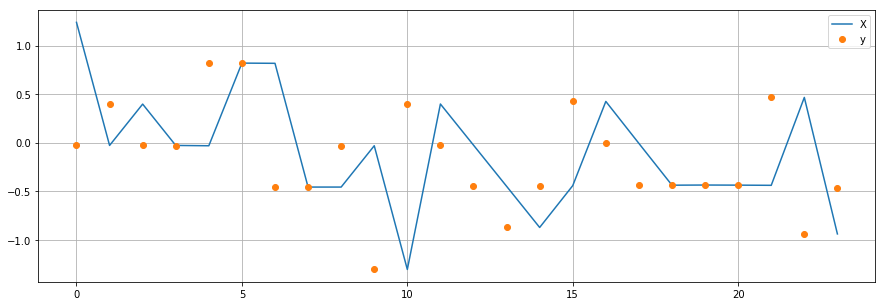

time: 301 ms


In [27]:
plt.figure(figsize=(15, 5))
plt.plot(X_train[-1])
plt.plot(y_train[-1], "o")
plt.legend(["X", "y"])
plt.grid(True)
plt.show()

In [44]:
num_time_steps = LAGS
# Number of series used to predict. (including concurrent)
num_inputs = 1
num_neurons = 64
# Number of output series
num_outputs = 1
learning_rate = 0.1
epochs = 500
# Training Settings
REPORT_PERIOD = 1

time: 1.17 ms


In [45]:
tf.reset_default_graph()
# setting up
X = tf.placeholder(
    tf.float32,
    [None, num_time_steps, num_inputs],
    name="Input_placeholder")
y = tf.placeholder(
    tf.float32,
    [None, num_time_steps, num_outputs],
    name="Output_placeholder")
# y = tf.placeholder(
#     tf.float32,
#     [None, 1, num_outputs],
#     name="Output_placeholder")

time: 5.82 ms


In [46]:
# Build RNN.
cell = tf.contrib.rnn.LSTMCell(
    num_units=num_neurons
)
    
rnn_output, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
# stacked_rnn_output = tf.reshape(rnn_output, [-1, num_neurons])

# stacked_outputs = tf.layers.dense(stacked_rnn_output, num_outputs)
# outputs = tf.reshape(stacked_outputs, [-1, num_time_steps, num_outputs])
# last_output = outputs[:, -1]
outputs = tf.layers.dense(rnn_output, num_outputs)

time: 148 ms


In [48]:
# Operators
loss = tf.reduce_sum(tf.square(outputs - y))
# loss = tf.reduce_sum(tf.square(last_output - y))
optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

time: 372 ms


In [56]:
y

<tf.Tensor 'Output_placeholder:0' shape=(?, 24, 1) dtype=float32>

time: 3.1 ms


In [49]:
hist = {"train": [], "val": []}
with tf.Session() as sess:
    sess.run(init)
    for e in range(epochs):
        sess.run(train,
                 feed_dict={X: X_train, y: y_train})
        if e % REPORT_PERIOD == 0:
            train_mse = loss.eval(feed_dict={X: X_train, y: y_train})
            val_mse = loss.eval(feed_dict={X: X_val, y: y_val})
            hist["train"].append(train_mse)
            hist["val"].append(val_mse)
            print(f"Iteration [{e}], Training MSE {train_mse:0.7f}; Validation MSE {val_mse:0.7f}")
    
    gen_pred = lambda src: outputs.eval(feed_dict={X: src})[:,-1]
    p_train = gen_pred(X_train)
    p_test = gen_pred(X_test)
    

Iteration [0], Training MSE 13033.8779297; Validation MSE 1136.5354004
Iteration [1], Training MSE 13027.7324219; Validation MSE 1136.0642090
Iteration [2], Training MSE 13021.5742188; Validation MSE 1135.5971680
Iteration [3], Training MSE 13015.4072266; Validation MSE 1135.1357422
Iteration [4], Training MSE 13009.2421875; Validation MSE 1134.6804199
Iteration [5], Training MSE 13003.0673828; Validation MSE 1134.2307129
Iteration [6], Training MSE 12996.9199219; Validation MSE 1133.7858887
Iteration [7], Training MSE 12990.7607422; Validation MSE 1133.3469238
Iteration [8], Training MSE 12984.6210938; Validation MSE 1132.9128418
Iteration [9], Training MSE 12978.5000000; Validation MSE 1132.4838867
Iteration [10], Training MSE 12972.3906250; Validation MSE 1132.0598145
Iteration [11], Training MSE 12966.2871094; Validation MSE 1131.6403809
Iteration [12], Training MSE 12960.2041016; Validation MSE 1131.2255859
Iteration [13], Training MSE 12954.1289062; Validation MSE 1130.8150635
It

Iteration [115], Training MSE 12282.2382812; Validation MSE 1101.0402832
Iteration [116], Training MSE 12270.2109375; Validation MSE 1100.8928223
Iteration [117], Training MSE 12257.6103516; Validation MSE 1100.7613525
Iteration [118], Training MSE 12244.3710938; Validation MSE 1100.6486816
Iteration [119], Training MSE 12230.4062500; Validation MSE 1100.5595703
Iteration [120], Training MSE 12215.6162109; Validation MSE 1100.4993896
Iteration [121], Training MSE 12199.9042969; Validation MSE 1100.4763184
Iteration [122], Training MSE 12183.1318359; Validation MSE 1100.5001221
Iteration [123], Training MSE 12165.1914062; Validation MSE 1100.5844727
Iteration [124], Training MSE 12145.9414062; Validation MSE 1100.7485352
Iteration [125], Training MSE 12125.3281250; Validation MSE 1101.0166016
Iteration [126], Training MSE 12103.3281250; Validation MSE 1101.4205322
Iteration [127], Training MSE 12080.0742188; Validation MSE 1101.9995117
Iteration [128], Training MSE 12055.9003906; Valida

Iteration [229], Training MSE 10683.5830078; Validation MSE 1108.4191895
Iteration [230], Training MSE 10687.4218750; Validation MSE 1062.5197754
Iteration [231], Training MSE 10670.7041016; Validation MSE 1106.8281250
Iteration [232], Training MSE 10673.6367188; Validation MSE 1062.4450684
Iteration [233], Training MSE 10658.4921875; Validation MSE 1105.8996582
Iteration [234], Training MSE 10661.1699219; Validation MSE 1061.9200439
Iteration [235], Training MSE 10648.2714844; Validation MSE 1106.3089600
Iteration [236], Training MSE 10653.1962891; Validation MSE 1060.6706543
Iteration [237], Training MSE 10644.2060547; Validation MSE 1108.2944336
Iteration [238], Training MSE 10655.9140625; Validation MSE 1059.6096191
Iteration [239], Training MSE 10647.7910156; Validation MSE 1107.9428711
Iteration [240], Training MSE 10662.9912109; Validation MSE 1060.8908691
Iteration [241], Training MSE 10648.4003906; Validation MSE 1101.6179199
Iteration [242], Training MSE 10655.9140625; Valida

Iteration [342], Training MSE 10318.7753906; Validation MSE 1053.6491699
Iteration [343], Training MSE 10302.6601562; Validation MSE 1103.5187988
Iteration [344], Training MSE 10312.9511719; Validation MSE 1053.6599121
Iteration [345], Training MSE 10296.9306641; Validation MSE 1103.1694336
Iteration [346], Training MSE 10307.1005859; Validation MSE 1053.6965332
Iteration [347], Training MSE 10291.2070312; Validation MSE 1102.7790527
Iteration [348], Training MSE 10301.2304688; Validation MSE 1053.7656250
Iteration [349], Training MSE 10285.4882812; Validation MSE 1102.3355713
Iteration [350], Training MSE 10295.3378906; Validation MSE 1053.8770752
Iteration [351], Training MSE 10279.7919922; Validation MSE 1101.8218994
Iteration [352], Training MSE 10289.4121094; Validation MSE 1054.0468750
Iteration [353], Training MSE 10274.1230469; Validation MSE 1101.2114258
Iteration [354], Training MSE 10283.4667969; Validation MSE 1054.3002930
Iteration [355], Training MSE 10268.4970703; Valida

Iteration [456], Training MSE 10049.3613281; Validation MSE 1054.5775146
Iteration [457], Training MSE 10041.6044922; Validation MSE 1086.9177246
Iteration [458], Training MSE 10046.4375000; Validation MSE 1052.8481445
Iteration [459], Training MSE 10039.8046875; Validation MSE 1089.2705078
Iteration [460], Training MSE 10044.0351562; Validation MSE 1050.9338379
Iteration [461], Training MSE 10038.6669922; Validation MSE 1091.9910889
Iteration [462], Training MSE 10043.8359375; Validation MSE 1048.7180176
Iteration [463], Training MSE 10039.3242188; Validation MSE 1095.2453613
Iteration [464], Training MSE 10051.0878906; Validation MSE 1046.2421875
Iteration [465], Training MSE 10045.1972656; Validation MSE 1098.2460938
Iteration [466], Training MSE 10067.4287109; Validation MSE 1044.3953857
Iteration [467], Training MSE 10053.4238281; Validation MSE 1098.4874268
Iteration [468], Training MSE 10066.1757812; Validation MSE 1044.2565918
Iteration [469], Training MSE 10044.3525391; Valida

In [50]:
# clean = lambda x: np.squeeze(x[:, -1: ])
# pred_train = clean(pred_train)
# pred_val = clean(pred_val)
# pred_test = clean(pred_test)

time: 1.33 ms


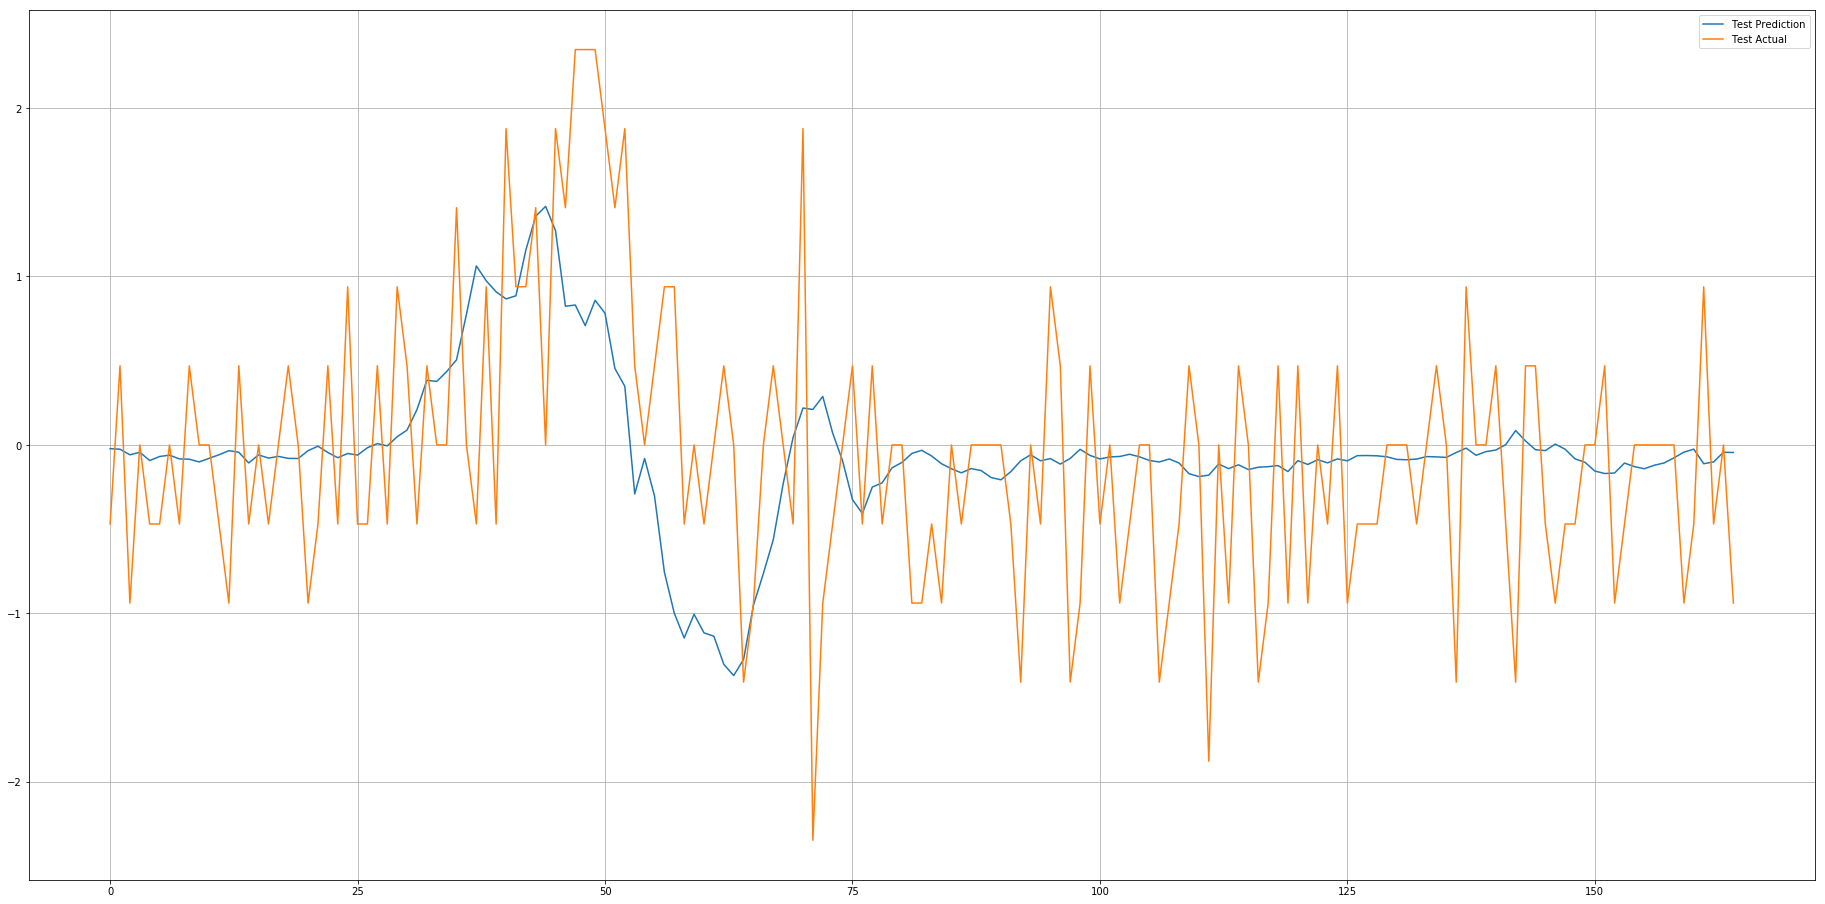

time: 966 ms


In [51]:
plt.close()
plt.figure(figsize=(32,16))
plt.plot(np.squeeze(p_test[:,-1]))
plt.plot(np.squeeze(y_test[:,-1]))
plt.legend(["Test Prediction", "Test Actual"])
plt.grid(True)
plt.show()

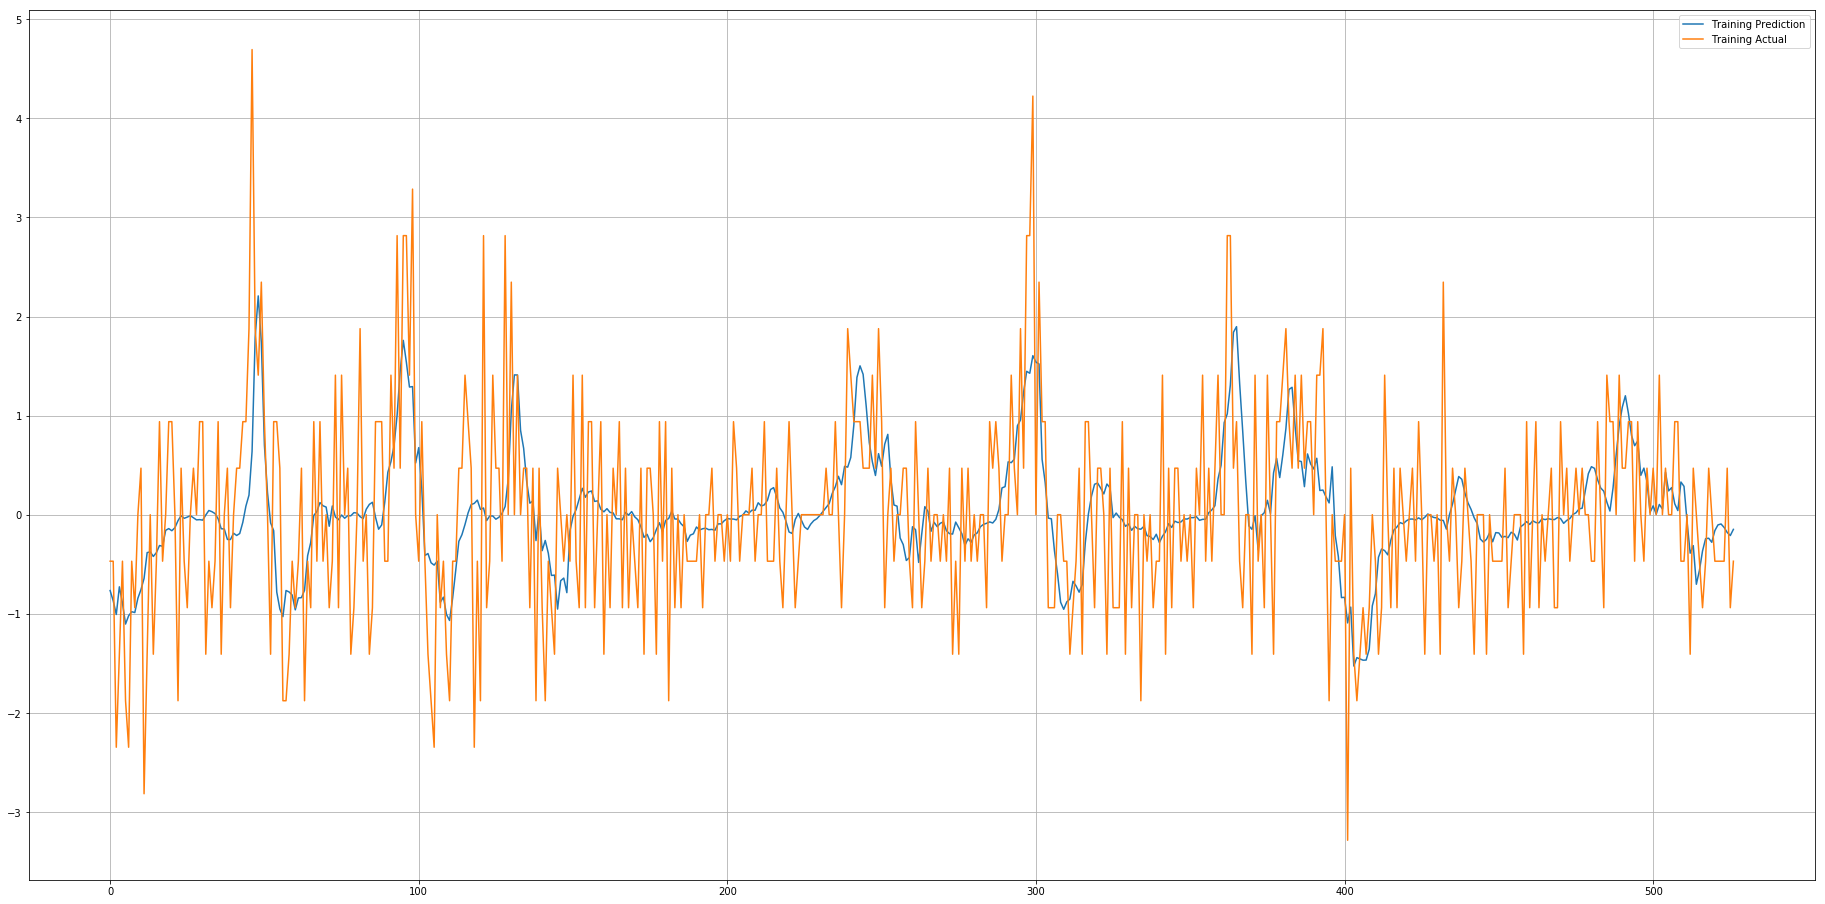

time: 1.01 s


In [52]:
plt.close()
plt.figure(figsize=(32,16))
plt.plot(np.squeeze(p_train))
plt.plot(np.squeeze(y_train[:,-1]))
plt.legend(["Training Prediction", "Training Actual"])
plt.grid(True)
plt.show()

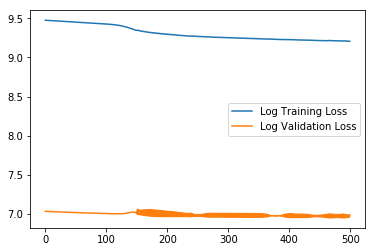

time: 201 ms


In [53]:
plt.close()
plt.plot(np.log(hist["train"]))
plt.plot(np.log(hist["val"]))
plt.legend(["Log Training Loss", "Log Validation Loss"])
plt.show()